In [1]:
!pip install transformers

In [2]:
!pip install pytorch-lightning

In [3]:
import os
os.chdir("/kaggle/input/antibiotic-protein")

In [4]:
import logging
import sys

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [5]:
import pytorch_lightning as pl
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc

In [7]:
from transformers import AdamW

In [8]:
import random  ,os
import numpy as np 
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#import requests
from tqdm.auto import tqdm

In [10]:
train_df = pd.read_csv("train (4).csv")
test_df = pd.read_csv("test (3).csv")

In [11]:
train_df.head()

ID                                           sequence  label
0  train_0  MKFQRIDLENWSRKSYFEHYLNRVNCTFSMTANIDITELLPALRQK...    1.0
1  train_1  MSKIELKQLSFAYDNQEALLFDQANITMDTNWKLGLIGRNGRGKTT...    1.0
2  train_2  MDLWTALQALILGVVEGLTEFLPISSTGHQIIVADLLEFGGERAMA...    0.0
3  train_3  KGLKGLLVLALGFTGLQVFGQQNPDIKIEKLKDNLYVYTTYNTFKG...    1.0
4  train_4  MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...    0.0

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11846 entries, 0 to 11845
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        11846 non-null  object 
 1   sequence  11846 non-null  object 
 2   label     11846 non-null  float64
dtypes: float64(1), object(2)
memory usage: 277.8+ KB


In [13]:
train_df.describe()

label
count  11846.000000
mean       0.517981
std        0.499698
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000

In [14]:
train_df.shape

(11846, 3)

In [15]:
train_df.sequence.nunique()

11846

**1 indicates that the gene is antibody resistant and 0 indicates that it is not.**

In [16]:
train_df["len_seq"] = train_df["sequence"].apply(lambda seq: len(seq))

In [17]:
train_df.head(10)

ID                                           sequence  label  len_seq
0  train_0  MKFQRIDLENWSRKSYFEHYLNRVNCTFSMTANIDITELLPALRQK...    1.0      219
1  train_1  MSKIELKQLSFAYDNQEALLFDQANITMDTNWKLGLIGRNGRGKTT...    1.0      498
2  train_2  MDLWTALQALILGVVEGLTEFLPISSTGHQIIVADLLEFGGERAMA...    0.0      276
3  train_3  KGLKGLLVLALGFTGLQVFGQQNPDIKIEKLKDNLYVYTTYNTFKG...    1.0      247
4  train_4  MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...    0.0      397
5  train_5  MTFNIIKLENWDRKEYFEHYFNQQTTYSITKEIDITLFKDMSKKKG...    1.0      215
6  train_6  MMKKSLCCALLLTASFSTFAAAKTEQQIADIVNRTITPLMQEQAIP...    1.0      381
7  train_7  MDTIVTAILLGILEGLTEFLPVSSTGHLILAQAWFGYDPALWRQYN...    0.0      269
8  train_8  TISAQVIETIVGWIDDNLHQPLRIDDIARHSGYSKWHLQRLFLQYK...    0.0      108
9  train_9  MAKLLIMSIVSFCFIFLLLLFFRYILKRYFNYMLNYKVWYLTLLAG...    1.0      585

 #### len sequences distribution

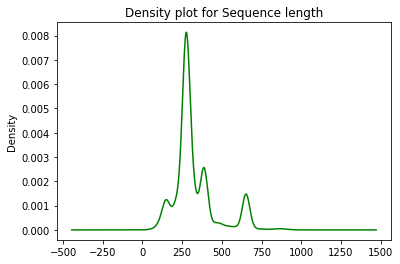

In [18]:
counts, bins = np.histogram(train_df["len_seq"])
#plt.hist(bins[:-1], bins, weights=counts)
train_df.len_seq.plot.density(color='green')
plt.title('Density plot for Sequence length')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'label')

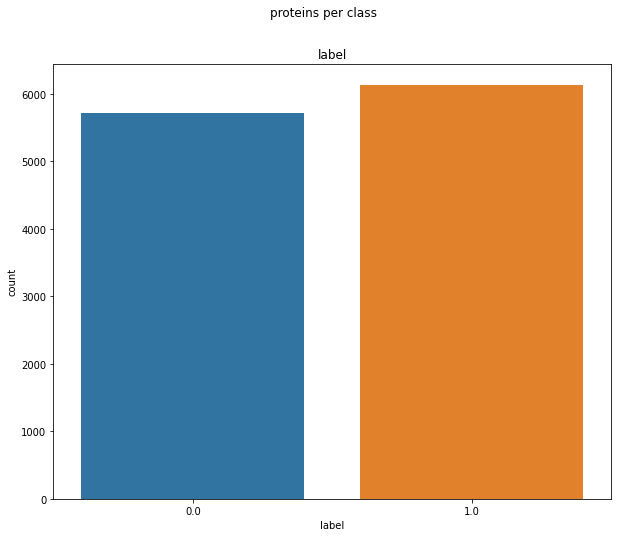

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), sharey=False)
fig.suptitle('proteins per class')

sns.countplot(train_df["label"] , ax=axes)
axes.set_title(train_df["label"].name)

### preprocessing

#### add spaces

In [20]:
train_df["sequence"] = train_df["sequence"].apply(lambda seq: " ".join(seq))

In [21]:
train_df["sequence"][:3]

0    M K F Q R I D L E N W S R K S Y F E H Y L N R ...
1    M S K I E L K Q L S F A Y D N Q E A L L F D Q ...
2    M D L W T A L Q A L I L G V V E G L T E F L P ...
Name: sequence, dtype: object

#### remove rare amino acid

In [22]:
train_df["sequence"] = train_df["sequence"].str.replace(r"[UZOB]", 'X', regex=True)

In [23]:
train_df["sequence"][:3]

0    M K F Q R I D L E N W S R K S Y F E H Y L N R ...
1    M S K I E L K Q L S F A Y D N Q E A L L F D Q ...
2    M D L W T A L Q A L I L G V V E G L T E F L P ...
Name: sequence, dtype: object

### train val split

In [24]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size=0.07, random_state=42,shuffle = True)
train.shape, val.shape

((11016, 4), (830, 4))

In [25]:
val.head()

ID                                           sequence  label  \
8187  train_8187  M D I R Q M N R T H L D H W R G L R K Q L W P ...    0.0   
900    train_900  M D L H L L I N A F I L G V V E G V T E F L P ...    0.0   
3898  train_3898  M F F A N I I K A A I L G I I E G I T E W L P ...    0.0   
9791  train_9791  M R Q Y R F A L L P L L A A L A L P G W A H Q ...    1.0   
2820  train_2820  M R Q P L L K L A A V T R R F P A G D K D V V ...    0.0   

      len_seq  
8187      145  
900       272  
3898      277  
9791      291  
2820      684

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'label')

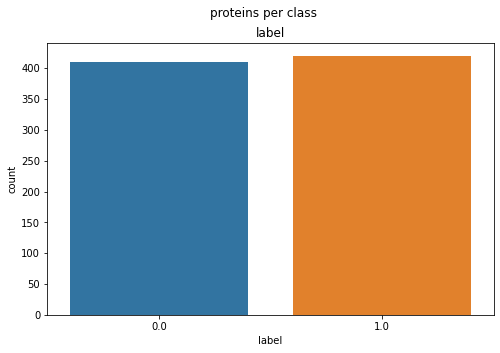

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5), sharey=False)
fig.suptitle('proteins per class')

sns.countplot(val["label"] , ax=axes)
axes.set_title(val["label"].name)

#### Tockenization

In [27]:
from transformers import BertModel, BertTokenizer
import re
import torch
BERT_MODEL_NAME = "Rostlab/prot_bert"

In [33]:
from torch.utils.data import TensorDataset

In [28]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, do_lower_case=False )
model = BertModel.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Dataloaders

In [29]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

Tokenization

In [30]:
encoded_data_train = tokenizer.batch_encode_plus(
    train["sequence"].values,
    truncation=True,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
)

encoded_data_val = tokenizer.batch_encode_plus(
    val["sequence"].values,
    truncation=True,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
)

In [31]:
input_ids_train = encoded_data_train["input_ids"]
attention_masks_train = encoded_data_train["attention_mask"]
labels_train = torch.tensor(train["label"].values)

input_ids_val = encoded_data_val["input_ids"]
attention_masks_val = encoded_data_val["attention_mask"]
labels_val = torch.tensor(val["label"].values)

In [34]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [35]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=4,
)
# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=4,
)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
device

device(type='cuda')

In [38]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False

## **Feature extraction using pretrained prot bert**

In [39]:
emb_train_list = []
class_train_list = []
model.eval()
for batch in tqdm(train_dataloader):
    batch = tuple(k.to(device) for k in batch)
    classes = batch[-1]
    inputs = {'input_ids':      batch[0],
            'attention_mask': batch[1],
            }
  # Extract per-residue embeddings (on GPU)
    with torch.no_grad():
        outputs = model(**inputs)

    embeddings_t = outputs.last_hidden_state
    embeddings_t = embeddings_t.detach().cpu().numpy()
    classes = classes.detach().cpu().numpy()
  # Generate per-sequence embeddings via averaging
    seq_emb = np.mean(embeddings_t, axis=1)
    emb_train_list.append(seq_emb)
    class_train_list.append(classes)

  0%|          | 0/2754 [00:00<?, ?it/s]

In [40]:
batch

(tensor([[ 2, 16,  6,  ...,  0,  0,  0],
         [ 2,  7,  9,  ...,  5, 14,  3],
         [ 2, 21, 15,  ...,  0,  0,  0],
         [ 2, 21, 17,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 tensor([1., 1., 0., 1.], device='cuda:0', dtype=torch.float64))

In [41]:
embeddings_t

array([[[ 0.03754749,  0.04604527,  0.11717051, ...,  0.01450668,
          0.07147583, -0.04940889],
        [ 0.02592022,  0.0824636 ,  0.11807744, ...,  0.10113591,
          0.05155008, -0.13363546],
        [ 0.01695045,  0.12056582, -0.03910448, ..., -0.03950716,
          0.0183626 ,  0.05870891],
        ...,
        [ 0.07613575,  0.01317246,  0.01111853, ..., -0.00423758,
         -0.06906591, -0.04358869],
        [-0.01291099,  0.06841868, -0.04653718, ..., -0.06989352,
         -0.08800873, -0.13061741],
        [ 0.07437246, -0.02126512, -0.05846091, ...,  0.01860134,
         -0.05262206, -0.06553944]],

       [[-0.01656998,  0.05697314,  0.13151424, ..., -0.02088941,
          0.05712342, -0.07808366],
        [ 0.19697253,  0.03289723,  0.14295852, ..., -0.07883498,
          0.04102175, -0.04042279],
        [ 0.24213938,  0.01432666,  0.01262516, ...,  0.00218196,
          0.09926523, -0.01461248],
        ...,
        [ 0.09118052, -0.03503806,  0.03194401, ..., -

In [42]:
embeddings_t.shape

(4, 256, 1024)

In [44]:
print(seq_emb)
print(seq_emb.shape)

[[ 0.02984454  0.0080643   0.01406946 ...  0.00769337 -0.00309277
  -0.01707898]
 [ 0.1492256   0.053333    0.03581239 ... -0.10344347 -0.08253713
  -0.03923635]
 [-0.01627205 -0.00700665 -0.00089515 ... -0.04643504 -0.0060746
  -0.01137834]
 [ 0.1407077   0.07722685  0.01988825 ... -0.08846057 -0.06293403
   0.00700589]]
(4, 1024)


In [45]:
emb_val_list = []
class_val_list = []
model.eval()
for batch in tqdm(val_dataloader):
    batch = tuple(k.to(device) for k in batch)
    classes = batch[-1]
    inputs = {'input_ids':      batch[0],
            'attention_mask': batch[1],
            }
  # Extract per-residue embeddings (on GPU)
    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state
    embeddings = embeddings.detach().cpu().numpy()
    classes = classes.detach().cpu().numpy()
  # Generate per-sequence embeddings via averaging
    seq_val_emb = np.mean(embeddings, axis=1)
    emb_val_list.append(seq_val_emb)
    class_val_list.append(classes)

  0%|          | 0/208 [00:00<?, ?it/s]

In [46]:
emb_train_vectors = np.concatenate(emb_train_list, axis=0)

In [47]:
emb_train_vectors.shape

(11016, 1024)

In [48]:
emb_train_vectors[1]

array([ 0.0062118 ,  0.02980438, -0.01547137, ..., -0.00179475,
        0.0098314 , -0.03880563], dtype=float32)

In [51]:
class_train_vectors = np.concatenate(class_train_list, axis=0)

In [52]:
class_train_vectors.shape

(11016,)

In [53]:
class_train_vectors[:10]

array([1., 0., 1., 0., 0., 0., 1., 0., 0., 0.])

In [45]:
from sklearn.preprocessing import LabelEncoder

In [47]:
label_encoder_class = LabelEncoder()

In [54]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

## **2D PCA visualization**

In [56]:
import plotly.express as px
seq_vectors = emb_train_vectors.copy()
two_dim = PCA(random_state=0, n_components=2).fit_transform(seq_vectors)
fig = px.scatter(x=two_dim[:,0], y=two_dim[:,1], color=class_train_vectors)
fig.show()

## **3D PCA for feature vizualisation**

In [57]:
seq_vectors = emb_train_vectors.copy()
n_dim = PCA(random_state=0, n_components=3).fit_transform(seq_vectors)
fig = px.scatter_3d(x=n_dim[:,0], y=n_dim[:,1], z=n_dim[:,2], color=class_train_vectors)
fig.show()

## **T-distributed Stochastic Neighbor Embedding**

### **2D vizualisation**

In [59]:
from sklearn.manifold import TSNE
fifty_dim = PCA(random_state=0, n_components=100).fit_transform(seq_vectors)
two_dim = TSNE(n_components=2).fit_transform(fifty_dim)
fig = px.scatter(x=two_dim[:,0], y=two_dim[:,1], color=class_train_vectors)
fig.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### **3D vizualisation**

In [60]:
fifty_dim = PCA(random_state=0, n_components=100).fit_transform(seq_vectors)
three_dim = TSNE(n_components=3).fit_transform(fifty_dim)
fig = px.scatter_3d(x=three_dim[:,0], y=three_dim[:,1], z=three_dim[:,2], color=class_train_vectors)
fig.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## **MD Scaling** 

## **2D vizualisations**

In [73]:
from sklearn.manifold import MDS
fifty_dims = PCA(random_state=0, n_components=50).fit_transform(seq_vectors)
md_scaling = MDS(n_components=3)
S_scaling = md_scaling.fit_transform(fifty_dims)
fig = px.scatter_3d(x=S_scaling[:,0], y=S_scaling[:,1], z=S_scaling[:,2], color=class_train_vectors)
fig.show()

ValueError: Array must be symmetric

In [63]:
fig = px.scatter(x=S_scaling[:,0], y=S_scaling[:,1], color=class_train_vectors)
fig.show()

In [68]:
fifty_dims = PCA(random_state=0, n_components=3).fit_transform(seq_vectors)
md_scaling = MDS(n_components=3)
S3_scaling = md_scaling.fit_transform(fifty_dims)
fig = px.scatter_3d(x=S3_scaling[:,0], y=S3_scaling[:,1], z=S3_scaling[:,2], color=class_train_vectors)
fig.show()

## **Spectral embeddings** 

In [69]:
from sklearn.manifold import SpectralEmbedding
fifty_dims = PCA(random_state=0, n_components=3).fit_transform(seq_vectors)
spectral = SpectralEmbedding(n_components=3)
S3_spectral = spectral.fit_transform(fifty_dims)

In [70]:
fig = px.scatter_3d(x=S3_spectral[:,0], y=S3_spectral[:,1], z=S3_spectral[:,2], color=class_train_vectors)
fig.show()

## **ISO map embeddings**

In [71]:
from sklearn.manifold import Isomap 
fifty_dims = PCA(random_state=0, n_components=3).fit_transform(seq_vectors)
isomap = Isomap(n_neighbors=2,n_components=3)
S_isomap = isomap.fit_transform(fifty_dims)
fig = px.scatter_3d(x=S_isomap[:,0], y=S_isomap[:,1], z=S_isomap[:,2], color=class_train_vectors)
fig.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/

In [72]:
from sklearn.manifold import Isomap 
fifty_dims = PCA(random_state=0, n_components=50).fit_transform(seq_vectors)
isomap = Isomap(n_components=3)
S_isomap = isomap.fit_transform(fifty_dims)
fig = px.scatter_3d(x=S_isomap[:,0], y=S_isomap[:,1], z=S_isomap[:,2], color=class_train_vectors)
fig.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_isomap.py:324: UserWarning:

The number of connected components of the neighbors graph is 66 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [59]:
from sklearn.svm import SVC
clf = SVC()

In [60]:
clf.fit(seq_vectors, class_vectors)

SVC()

In [48]:
#class_vectors_name = label_encoder_class.inverse_transform(class_vectors)

NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### finetuning bert pretrained model

In [ ]:
#from transformers import BertForSequenceClassification
from transformers import BertModel
BERT_MODEL_NAME = "Rostlab/prot_bert"

In [ ]:
BATCH_SIZE = 8
N_EPOCHS = 20

In [ ]:
steps_per_epoch=len(train) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
len(train_dataloader)

In [ ]:
len(val)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def trainer(model, train_dataloader, val_dataloader, learning_rate, epochs , len_val , len_train):

    #train, val = Dataset(train_data), Dataset(val_data)

    #train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    #val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
            
    val_loss_list = []
  
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for batch in tqdm(train_dataloader):
                batch = tuple(b.to(device) for b in batch)
                inputs = {'input_ids':      batch[0],
                        'attention_mask': batch[1],
                        'labels':         batch[2],
                        }

                train_label = inputs['labels']
                mask = inputs['attention_mask']
                input_id = inputs['input_ids']

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_b in val_dataloader:
                    val_b = tuple(b.to(device) for b in val_b)
        
                    val_input = {'input_ids':      val_b[0],
                              'attention_mask': val_b[1],
                              'labels':         val_b[2],
                              }

                    val_label = val_input["labels"]
                    mask = val_input['attention_mask']
                    input_id = val_input['input_ids']

                    

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            current_val_loss = total_loss_val
            val_loss_list.append(total_loss_val)
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len_train: .3f} \
                | Train Accuracy: {total_acc_train /len_train: .3f} \
                | Val Loss: {total_loss_val / len_val: .3f} \
                | Val Accuracy: {total_acc_val / len_val: .3f}')
            
            if current_val_loss == min(val_loss_list):
                path = os.path.join('/kaggle/working', "epoch"+str(epoch_num + 1)+'_model.pth')
                # recommended way from http://pytorch.org/docs/master/notes/serialization.html
                torch.save(model.state_dict(), path)
                logger.info(f"Saving model: {path} \n")

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn.functional as F
import torch.nn as nn


#PRE_TRAINED_MODEL_NAME = BERT_MODEL_NAME
PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert_bfd_localization'
class ProteinClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ProteinClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.classifier = nn.Sequential(nn.Dropout(p=0.7),
                                        nn.Linear(self.bert.config.hidden_size, n_classes),
                                        nn.Sigmoid())
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        return self.classifier(output.pooler_output)

In [ ]:
#from transformers import BertForSequenceClassification
#model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=2,output_attentions=False,output_hidden_states=False)

In [ ]:
epochs = 50
learning_rate = 2e-5
#model = ProteinClassifier()
model = ProteinClassifier(2)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
len_train = len(train)
len_val = len(val)

In [ ]:
trainer(model, train_dataloader, val_dataloader, learning_rate, epochs, len_val, len_train)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


In [ ]:
!nvidia-smi 

In [ ]:
def save_model(model):
    path = os.path.join('/content/drive/MyDrive/Iovision_workspace/Logs', 'model.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.state_dict(), path)
    logger.info(f"Saving model: {path} \n")

#### test preprocessing

In [61]:
test_df = pd.read_csv("/kaggle/input/antibiotic-protein/test (3).csv")

In [62]:
test_df.head()

ID                                           sequence
0  test_0  MPQHLLSGVRNFTALAVFIAAGNCLAATDLQAVVDANVKPLMQQQA...
1  test_1  MAELPQSRINERNITSEMRESFLDYAMSVIVARALPDVRDGLKPVH...
2  test_2  MSYRDLGLIDSEVIAERRVRALDDSSPSAVPTTGVRVFGCGHDEAV...
3  test_3  MMIKSLCCALLLGLSCSALAAPVSEKQLAEVVANTVTPLMKAQSVP...
4  test_4  MTTLEALILGIIQGVFMFVPVSSTSHLALAQHWLISAGSGMPAPDS...

In [ ]:
test_df.columns

In [63]:
test_df["sequence"] = test_df["sequence"].apply(lambda seq: " ".join(seq))

In [64]:
test_df["sequence"] = test_df["sequence"].str.replace(r"[UZOB]", 'X', regex=True)

In [65]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df["sequence"].values,
    truncation=True,
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
)

In [66]:
input_ids_test = encoded_data_test["input_ids"]
attention_masks_test = encoded_data_test["attention_mask"]
#labels_test = torch.tensor(test_df["label"].values)

In [67]:
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

In [73]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=2,)

In [70]:
device

device(type='cuda')

In [71]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False

In [76]:
batch 

[tensor([[ 2, 21, 16,  ...,  0,  0,  0],
         [ 2, 21,  6,  ..., 11, 15,  3]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]])]

In [80]:
CUDA_LAUNCH_BLOCKING=1

In [81]:
emb_tst_list = []
#class_list = []
model.eval()
for batched in test_dataloader:
    
    batched = tuple(k.to(device) for k in batched)
    
    #classes = batch[-1]
    inputs = {'input_ids':      batched[0],
            'attention_mask': batched[1],
            }
  # Extract per-residue embeddings (on GPU)
    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state
    embeddings = embeddings.detach().cpu().numpy()
    #classes = classes.detach().cpu().numpy()
  # Generate per-sequence embeddings via averaging
    seq_tst_emb = np.mean(embeddings, axis=1)
    emb_tst_list.append(seq_tst_emb)
    #class_list.append(classes)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def cross_entroy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=-1).flatten()
    labels_flat = labels.flatten()
    return log_loss(labels_flat, preds_flat)

#### evaluation

In [ ]:
def test(model, test_loader, device):
    model.eval()
    
    predictions = []
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(b.to(device) for b in batch)
        
            inputs = {'input_ids':      batch[0],
                       'attention_mask': batch[1],
                      }
            b_input_ids = inputs['input_ids']
            b_input_mask = inputs['attention_mask']

            outputs = model(b_input_ids,attention_mask=b_input_mask)
            #outputs = sigmoid(self.model(inputs, sequence_len))
            _, preds = torch.max(outputs, dim=1)
            #logits = outputs.logits
       
            # Move logits and labels to CPU
            preds = preds.detach().cpu().numpy()
            #label_ids = inputs['labels'].cpu().numpy()
            predictions.append(preds)
        
            
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [ ]:
#test(model,test_dataloader,"cuda")

#### load model

In [ ]:
#model = ProteinClassifier(2)

In [ ]:
os.getcwd()

In [ ]:
#model_inf = model = ProteinClassifier(2)  # we do not specify pretrained=True, i.e. do not load default weights
#model_inf.load_state_dict(torch.load('/content/drive/MyDrive/Iovision_workspace/Logs/1model_train2.pth'))

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
#model.to(device)

In [ ]:
#Test predictions and make the submission file 
test_perds = test(model_inf,test_dataloader,device)


In [ ]:
test_predictions=test_perds
test_df["label"]=test_predictions
test_df[["ID","label"]].to_csv("./pred5.csv",index=False)